<img src="a20_a21_a22_jaccard.svg" style="text-align:center;width:50%;display:inline;"><img src="a20_a21_a22_partial.svg" style="text-align:center;width:50%;display:inline;">

# Series

### Series properties:
* __bracketing__ — when items are listed together they are implictly lumped into the same category. Example: 'The all male Saudi rulers, Catholic priesthood, Taliban, and the boys club running Enron.'
* __order (incrementum)__  — Item are listed in an increasing or decreasing order. Example: 'No corporal, sergeant, lietenant, captain, major, or general could order me to do something that was against my religion.'
* __gradatio__  — lists of items with overlapping, suggesting a chain of causality. Example: 'Add to your faith virtue, to virtue knowledge, to knowledge self-control, ....'
* __polysyndenton__  — using conjunctions between every item. Example: 'The forces of truth and love and courage and honesty.'
* __asyndenton__  — not using any conjunctions when listing items. Example: 'I came, I saw, I conquered.'


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [2]:
importlib.reload(utils)
connection = utils.connectDB()

In [3]:
FEATURE = "Series"

In [4]:
# IMPORTANT: GPT data was corrected. Read the corrected GPT sheet NOT the database
gpt_df = pd.read_csv("corrected_GPT_min.csv")

In [5]:
# When this data is read in the majority_prop Type is incomaptible with the script downstream, so we just recreate this column each time
gpt_df['majority_prop'] = [list(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df['all_properties']]

In [6]:
gpt_df.head()

,sentence_id,all_properties,feature_id,majority_prop
0,265,"[{'simple'}, {'simple'}, {'simple'}, {'simple'...",Aspect,[simple]
1,265,"[{'indicative'}, {'indicative'}, {'indicative'}]",Mood,[indicative]
2,265,[],Verb_choices,[]
3,265,"[{'subordinate'}, {'subordinate', 'adjective'}...",Modifying_clauses,"[adjective, subordinate]"
4,265,"[{'multiplying and embedding modifiers', 'sing...",Modifying_phrases,"[multiplying and embedding modifiers, preposit..."


In [7]:
query = 'select * from annotations where annotator_id in (20,21,22) and completed=1;'
annotations = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### Format the human annotations like GPT for making comaprisons
This will roll the annotations up to the sentence level

In [8]:
a_20 = utils.annotationsToGPTFormat(20,annotations)
a_21 = utils.annotationsToGPTFormat(21,annotations)
a_22 = utils.annotationsToGPTFormat(22,annotations)

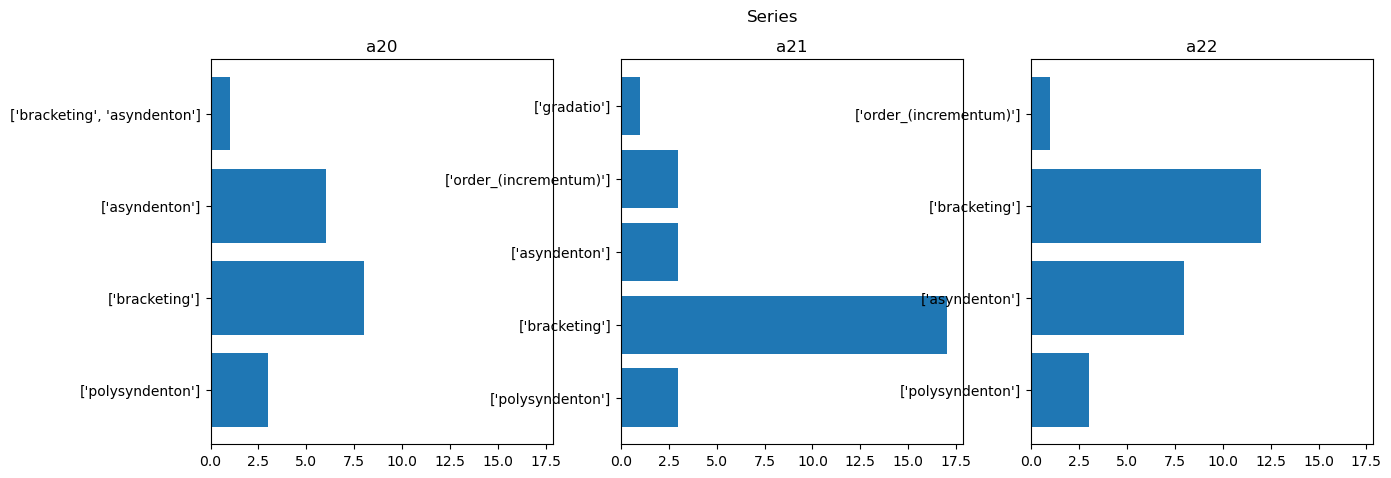

In [9]:
utils.plotPropertyDistributions(FEATURE,a_20,a_21,a_22)

In [10]:
features_gpt = list(gpt_df.groupby('feature_id').agg(list).reset_index()['feature_id'])
idx_gpt = features_gpt.index(FEATURE)
gpt_df_properties = gpt_df.groupby('feature_id').agg(list).reset_index().loc[idx_gpt][['all_properties','sentence_id']]
cGPT = Counter([str(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df_properties['all_properties']])

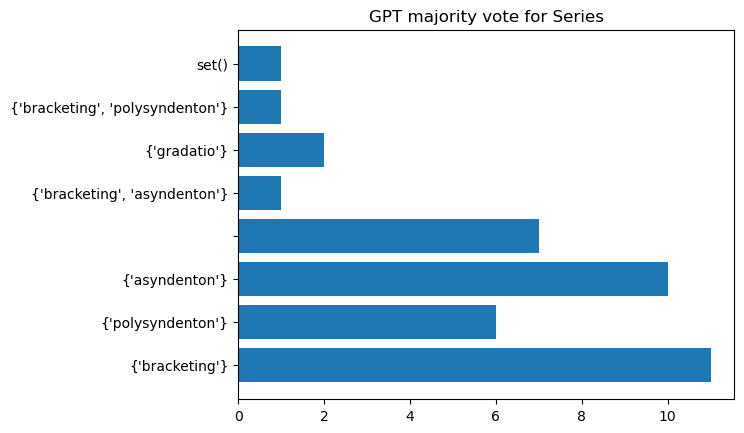

In [11]:
plt.barh(list(cGPT.keys()),list(cGPT.values()))
plt.title("GPT majority vote for "+FEATURE)
plt.show()

### Find all the sentences where there is agreement on the majority property



In [13]:
majority_property = 'bracketing'

In [14]:
a_20_sent = set(a_20[a_20['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
a_21_sent = set(a_21[a_21['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
a_22_sent = set(a_22[a_22['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
gpt_df_sent = set(gpt_df[gpt_df['majority_prop'].apply(lambda x: x == [majority_property])]['sentence_id'])

In [15]:
all_agreed_sentences = a_20_sent.intersection(a_21_sent,a_22_sent,gpt_df_sent)

In [16]:
len(all_agreed_sentences)

1

### Find all the sentences (and the respective annotations) that are not in the agreed sentences list

### Find all sentences

In [17]:
query = 'SELECT id, technique, text FROM ebdb.sample_sentences;'
non_agreed_sentences = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [18]:
non_agreed_sentences['feature_id'] = FEATURE
non_agreed_sentences['props_a20'] = ''
non_agreed_sentences['props_a21'] = ''
non_agreed_sentences['props_a22'] = ''
non_agreed_sentences['props_gpt'] = ''

In [19]:
non_agreed_sentences = non_agreed_sentences[['id', 'technique', 'text', 'feature_id', 'props_a20', 'props_a21', 'props_a22', 'props_gpt']]
non_agreed_sentences = non_agreed_sentences.rename(columns={'id':'sentence_id'})

In [20]:
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Series,,,,
1,11,[0 8],We are simply asked to take the pope’s word fo...,Series,,,,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Series,,,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Series,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Series,,,,


In [21]:
utils.fillInAnnotations(non_agreed_sentences,a_20,a_21,a_22,gpt_df,FEATURE)

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Series,,,,
1,11,[0 8],We are simply asked to take the pope’s word fo...,Series,,,,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Series,,,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Series,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Series,,,,
...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Series,,,,
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Series,,,,
354,14878,[],"In 1953, the CIA was in the process of develop...",Series,,,,
355,15168,[],"“If code is speech, the constitutional contrad...",Series,,,,


In [22]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

### Find rows with missing GPT responses

In [23]:
to_reprompt = non_agreed_sentences[non_agreed_sentences['props_gpt']=='']

In [24]:
print(len(to_reprompt))
to_reprompt.head()

318


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Series,,,,
1,11,[0 8],We are simply asked to take the pope’s word fo...,Series,,,,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Series,,,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Series,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Series,,,,


### Reprompt GPT 3 times and merge with non_agreed_sentences

In [24]:
# model = "gpt-3.5-turbo-0301"
# model = "gpt-3.5-turbo-0613"
# model = "gpt-3.5-turbo-1106"
# model = "gpt-4"

In [29]:
import GPT
importlib.reload(GPT)
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/utils.py'>

In [26]:
def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    responses = []
    gpt = GPT.GPT("gpt-3.5-turbo-1106")

    for row in tqdm(to_reprompt.iterrows()):
        sentence = row[1]['text']
        feature = row[1]['feature_id']
        sid = row[1]['sentence_id']
        promt, response = gpt.get_gpt_response(sentence,feature,sid)
        responses.append([sid, response])

    df = pd.DataFrame(responses, columns=['sentence_id','res'+str(i)])
    df['gpt_props'+str(i)] = df['res'+str(i)].apply(parseRes)
    non_agreed_sentences = non_agreed_sentences.merge(df, how='outer',on='sentence_id')
    non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

    print(f"There were {len(gpt.errors)} errors in round {i}.")

318it [32:12,  6.08s/it] 


There were 5 errors in round 1.


318it [1:10:54, 13.38s/it]


There were 13 errors in round 2.


318it [40:27,  7.63s/it] 

There were 7 errors in round 3.


In [27]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Series,NaN,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio']
1,11,[0 8],We are simply asked to take the pope’s word fo...,Series,NaN,NaN,NaN,NaN,"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],"{\n ""Properties"": [""gradatio"", ""asyndenton""],...","['gradatio',_'asyndenton']","{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton']
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Series,NaN,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton']
3,16,[0],"According to Breitbart, “Sellner, who describe...",Series,NaN,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],"{\n ""Properties"": [""asyndenton""],\n ""Exp...",['asyndenton']
4,23,[0],“This is a clear violation of the Senate Ethic...,Series,NaN,NaN,NaN,NaN,"``` \n{\n ""Properties"": [""polysyndenton"", ""br...",[],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton']


In [28]:
# get the majority vote from the annotators (props_a20, props_a21, props_a22)

# What to do when there is no majority? NA?


non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a20']+", "+\
                                           non_agreed_sentences['props_a21']+", "+\
                                           non_agreed_sentences['props_a22'] #.apply(utils.find_majority)

def convert(x):
    try: result = list(ast.literal_eval(x))
    except: result = [[]]
    return result

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(convert)
non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(lambda l: utils.find_majority(l)[0])

In [29]:
# get the majority vote from the reprompt (gpt_props1, gpt_props2, gpt_props3)

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['gpt_props1']+", "+\
                                           non_agreed_sentences['gpt_props2']+", "+\
                                           non_agreed_sentences['gpt_props3'] #.apply(utils.find_majority)

def convert(x):
    try: result = list(ast.literal_eval(x))
    except: result = [[]]
    return result

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(lambda l: utils.find_majority(l)[0])

In [30]:
# Merge the previous gpt props with the newly reprompted ones into a single column
def convert(x):
    try: 
        result = list(ast.literal_eval(x))
        result = [r.replace(" ","_") for r in result]
    except: 
        result = []
    return result

non_agreed_sentences['props_gpt'] = non_agreed_sentences['props_gpt'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'] + non_agreed_sentences['props_gpt']
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt'], axis=1)


### Calculate agreement between annotator majority and GPT majority

One issue is that when there is no majority the last item is selected

In [31]:
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

In [32]:
# save the final version
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

In [33]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],[],['gradatio'],-1
1,11,[0 8],We are simply asked to take the pope’s word fo...,Series,NaN,NaN,NaN,"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],"{\n ""Properties"": [""gradatio"", ""asyndenton""],...","['gradatio',_'asyndenton']","{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton'],[],[],1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],[],['asyndeton'],-1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],"{\n ""Properties"": [""asyndenton""],\n ""Exp...",['asyndenton'],[],['asyndenton'],-1
4,23,[0],“This is a clear violation of the Senate Ethic...,Series,NaN,NaN,NaN,"``` \n{\n ""Properties"": [""polysyndenton"", ""br...",[],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton'],[],[],1


# FIX ALL THE ERRORS
(Majorities are calculated at the list level, not the item level for both annotators and GPT)

In [6]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [7]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/utils.py'>

In [8]:
FEATURE = "Series"

In [9]:
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    non_agreed_sentences['gpt_props'+str(i)] = non_agreed_sentences['res'+str(i)].apply(parseRes)

def listOfLists(*lists):
    new_list = []
    for l in lists:
        if len(l):
            new_list.append(l)
    return new_list

non_agreed_sentences['props_gpt_list'] = non_agreed_sentences.apply(lambda x: listOfLists(x['gpt_props1'],
                                                                                          x['gpt_props2'],
                                                                                          x['gpt_props3']), axis=1)
def find_majority(row):
    if len(row.props_gpt_list):
        return utils.find_majority(row.props_gpt_list)[0]
    else:
        return row.props_gpt_majority
    
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences.apply(lambda x: find_majority(x),axis=1)
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt_list'], axis=1)

# # the old GPT majorities still have spaces. Remove spaces
def replaceSpaces(x):
    if type(x) == str:
        x = ast.literal_eval(x)
    x = [i.replace(" ","_") for i in x]
    return x

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(replaceSpaces)
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")


In [10]:
non_agreed_sentences

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],[],['gradatio'],-1
1,11,[0 8],We are simply asked to take the pope’s word fo...,Series,NaN,NaN,NaN,"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],"{\n ""Properties"": [""gradatio"", ""asyndenton""],...","['gradatio', 'asyndenton']","{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton'],[],['gradatio'],-1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],[],['asyndeton'],-1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],"{\n ""Properties"": [""asyndenton""],\n ""Exp...",['asyndenton'],[],['asyndenton'],-1
4,23,[0],“This is a clear violation of the Senate Ethic...,Series,NaN,NaN,NaN,"``` \n{\n ""Properties"": [""polysyndenton"", ""br...","['polysyndenton', 'bracketing']","{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton'],[],"['polysyndenton', 'bracketing']",-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],"{\n ""Properties"": [""bracketing""],\n ""Explana...",['bracketing'],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],[],['asyndeton'],-1
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],"{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndeton'],[],['asyndeton'],-1
354,14878,[],"In 1953, the CIA was in the process of develop...",Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],[],['asyndenton'],-1
355,15168,[],"“If code is speech, the constitutional contrad...",Series,NaN,NaN,NaN,"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"```json\n{\n ""Properties"": [""asyndeton"", ""pol...","['asyndeton', 'polysyndenton']",[],['asyndenton'],-1


# Fix more errors

1. parse GPT response again taking account of new lines
2. Fix property names
3. Recalculate the GPT majority
4. Get the annotators majority vote accounting for NaNs
5. Recalculate agreement

In [11]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [12]:
import GPT
importlib.reload(GPT)
gpt = GPT.GPT("gpt-3.5-turbo-1106")

In [13]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/utils.py'>

In [14]:
FEATURE = "Series"
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

### 1. parse GPT response again taking account of new lines

In [15]:
def parseRes(x):
    try:
        result = gpt.parseResponse(x)[1][0]
    except:
        result = gpt.parseResponse(x)[1]
    return result

non_agreed_sentences['gpt_props1'] = non_agreed_sentences.apply(lambda x: parseRes(x.res1),axis=1)
non_agreed_sentences['gpt_props2'] = non_agreed_sentences.apply(lambda x: parseRes(x.res2),axis=1)
non_agreed_sentences['gpt_props3'] = non_agreed_sentences.apply(lambda x: parseRes(x.res3),axis=1)

### 2. Fix property names

In [17]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

In [18]:
# Do we need to fix property names?

l1 = set(non_agreed_sentences['gpt_props1'].unique())
l2 = set(non_agreed_sentences['gpt_props2'].unique())
l3 = set(non_agreed_sentences['gpt_props3'].unique())
l1.union(l2,l3)

{"['asyndenton', 'bracketing']",
 "['asyndenton', 'gradatio']",
 "['asyndenton', 'polysyndenton', 'gradatio']",
 "['asyndenton', 'polysyndenton']",
 "['asyndenton']",
 "['asyndeton', 'polysyndenton']",
 "['asyndeton', 'polysyndeton']",
 "['asyndeton']",
 "['bracketing', 'asyndenton']",
 "['bracketing', 'asyndeton']",
 "['bracketing', 'gradatio']",
 "['bracketing', 'order_(incrementum)']",
 "['bracketing', 'polysyndenton', 'asyndenton']",
 "['bracketing', 'polysyndenton']",
 "['bracketing', 'polysyndeton']",
 "['bracketing']",
 "['gradatio', 'asyndenton']",
 "['gradatio', 'polysyndenton']",
 "['gradatio']",
 "['order']",
 "['order_(incrementum)']",
 "['polysyndenton', 'asyndenton']",
 "['polysyndenton', 'bracketing']",
 "['polysyndenton', 'gradatio']",
 "['polysyndenton']",
 "['polysyndeton', 'asyndeton']",
 "['polysyndeton']",
 '[]'}

In [20]:
# Correct the GPT properties to match the annotators
def mapProp(x):
    if type(x) == str:
        return [gpt.mapToProperty(elem,FEATURE) for elem in ast.literal_eval(x)]
    else:
        return [gpt.mapToProperty(elem,FEATURE) for elem in x]

for col in ['gpt_props1','gpt_props2','gpt_props3']:
    non_agreed_sentences[col] = non_agreed_sentences[col].apply(lambda x: mapProp(x))

### 3. Recalculate the GPT majority

In [21]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

In [22]:
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['gpt_props1']+", "+\
                                           non_agreed_sentences['gpt_props2']+", "+\
                                           non_agreed_sentences['gpt_props3']

def convert(x):
    try: result = list(ast.literal_eval(x))
    except: result = [[]]
    return result

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(lambda l: utils.find_majority(l)[0])

### 4. Get the annotators majority vote accounting for NaNs

In [23]:
non_agreed_sentences.loc[16]

sentence_id                                                         127
technique                                                           [1]
text                  I have seen a veritable chorus of Catholics on...
feature_id                                                       Series
props_a20                                                           NaN
props_a21                                                           NaN
props_a22                                                           NaN
res1                  {\n  "Properties": ["polysyndenton"],\n  "Expl...
gpt_props1                                            ['polysyndenton']
res2                  {\n  "Properties": ["polysyndenton"],\n  "Expl...
gpt_props2                                            ['polysyndenton']
res3                  {\n  "Properties": ["asyndenton"],\n  "Explana...
gpt_props3                                               ['asyndenton']
props_a_majority                                                

In [24]:
non_agreed_sentences[['props_a20','props_a21','props_a22']] = non_agreed_sentences[['props_a20','props_a21','props_a22']].fillna('[]')

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a20']+", "+\
                                           non_agreed_sentences['props_a21']+", "+\
                                           non_agreed_sentences['props_a22']

def convert(x):
    # try: result = ast.literal_eval(x)
    # except: result = [[]]
    # return result
    return list(ast.literal_eval(x))

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(convert)
non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(lambda l: utils.find_majority(l)[0])

In [25]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

### 5. Recalculate agreement

In [26]:
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

In [27]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

In [28]:
non_agreed_sentences

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Series,[],[],[],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],[],['gradatio'],-1
1,11,[0 8],We are simply asked to take the pope’s word fo...,Series,[],[],[],"{\n ""Properties"": [""gradatio""],\n ""Explanati...",['gradatio'],"{\n ""Properties"": [""gradatio"", ""asyndenton""],...","['gradatio', 'asyndenton']","{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton'],[],['gradatio'],-1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Series,[],[],[],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndenton'],[],['asyndenton'],-1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Series,[],[],[],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndenton'],"{\n ""Properties"": [""asyndenton""],\n ""Exp...",['asyndenton'],[],['asyndenton'],-1
4,23,[0],“This is a clear violation of the Senate Ethic...,Series,[],[],[],"``` \n{\n ""Properties"": [""polysyndenton"", ""br...","['polysyndenton', 'bracketing']","{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton'],[],"['polysyndenton', 'bracketing']",-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Series,[],[],[],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndenton'],"{\n ""Properties"": [""bracketing""],\n ""Explana...",['bracketing'],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],[],['asyndenton'],-1
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Series,[],[],[],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndenton'],"{\n ""Properties"": [""polysyndenton""],\n ""Expl...",['polysyndenton'],"{\n ""Properties"": [""asyndeton""],\n ""Explanat...",['asyndenton'],[],['asyndenton'],-1
354,14878,[],"In 1953, the CIA was in the process of develop...",Series,[],[],[],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],[],['asyndenton'],-1
355,15168,[],"“If code is speech, the constitutional contrad...",Series,[],[],[],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"{\n ""Properties"": [""asyndenton""],\n ""Explana...",['asyndenton'],"```json\n{\n ""Properties"": [""asyndeton"", ""pol...","['asyndenton', 'polysyndenton']",[],['asyndenton'],-1
